In [1]:
import pandas as pd

In [2]:
df= pd.read_csv(r'C:\Users\vedant\Downloads\it_monitoring_dummy_dataset.csv')

In [3]:
df.head()

,timestamp,server_id,cpu_usage,memory_usage,network_in,network_out
0,2025-09-21 13:32:53.298515,server_1,38.205605,42.627819,220.378534,155.392415
1,2025-09-21 13:33:53.298515,server_1,34.143629,55.913979,328.611467,92.834559
2,2025-09-21 13:34:53.298515,server_1,58.814456,64.617298,167.870998,298.336520
3,2025-09-21 13:35:53.298515,server_1,41.818641,66.904956,390.638565,146.481338
4,2025-09-21 13:36:53.298515,server_1,49.550552,43.987325,110.071784,233.822545


In [4]:
df.isnull().sum()

timestamp       0
server_id       0
cpu_usage       0
memory_usage    0
network_in      0
network_out     0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100800 entries, 0 to 100799
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   timestamp     100800 non-null  object 
 1   server_id     100800 non-null  object 
 2   cpu_usage     100800 non-null  float64
 3   memory_usage  100800 non-null  float64
 4   network_in    100800 non-null  float64
 5   network_out   100800 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.6+ MB


In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f') 

In [7]:
df.set_index('timestamp', inplace=True)
df.dtypes

server_id        object
cpu_usage       float64
memory_usage    float64
network_in      float64
network_out     float64
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100800 entries, 2025-09-21 13:32:53.298515 to 2025-10-05 13:31:53.298515
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   server_id     100800 non-null  object 
 1   cpu_usage     100800 non-null  float64
 2   memory_usage  100800 non-null  float64
 3   network_in    100800 non-null  float64
 4   network_out   100800 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


In [9]:
df.index

DatetimeIndex(['2025-09-21 13:32:53.298515', '2025-09-21 13:33:53.298515',
               '2025-09-21 13:34:53.298515', '2025-09-21 13:35:53.298515',
               '2025-09-21 13:36:53.298515', '2025-09-21 13:37:53.298515',
               '2025-09-21 13:38:53.298515', '2025-09-21 13:39:53.298515',
               '2025-09-21 13:40:53.298515', '2025-09-21 13:41:53.298515',
               ...
               '2025-10-05 13:22:53.298515', '2025-10-05 13:23:53.298515',
               '2025-10-05 13:24:53.298515', '2025-10-05 13:25:53.298515',
               '2025-10-05 13:26:53.298515', '2025-10-05 13:27:53.298515',
               '2025-10-05 13:28:53.298515', '2025-10-05 13:29:53.298515',
               '2025-10-05 13:30:53.298515', '2025-10-05 13:31:53.298515'],
              dtype='datetime64[ns]', name='timestamp', length=100800, freq=None)

In [10]:
resampled_df = (
    df.groupby('server_id')
      .resample('5min')
      .mean()
      .reset_index()
)

In [11]:
resampled_df.head()

,server_id,timestamp,cpu_usage,memory_usage,network_in,network_out
0,server_1,2025-09-21 13:30:00,43.721230,54.386365,238.953667,182.187831
1,server_1,2025-09-21 13:35:00,46.525297,58.174213,280.639143,175.216650
2,server_1,2025-09-21 13:40:00,41.337042,58.262633,355.601771,105.585471
3,server_1,2025-09-21 13:45:00,42.590264,52.987438,235.715567,146.764014
4,server_1,2025-09-21 13:50:00,44.245519,53.709883,398.088350,175.590833


In [12]:
from sklearn.ensemble import IsolationForest

# Example thresholds for manual anomaly detection
cpu_threshold = 90
memory_threshold = 10 # 10% increase over 30 minutes
network_threshold = 10000  # 10,000 bytes

In [13]:
resampled_df['cpu_anomaly'] = resampled_df.groupby('server_id')['cpu_usage'].apply(
    lambda x: (x > cpu_threshold).rolling(window=5).sum() >= 5
).reset_index(level=0, drop=True)

# Apply rolling window for Memory anomaly detection for each server
resampled_df['memory_anomaly'] = resampled_df.groupby('server_id')['memory_usage'].apply(
    lambda x: x.diff(6) > memory_threshold
).reset_index(level=0, drop=True)

# Apply rolling window for Network anomaly detection for each server
resampled_df['network_anomaly'] = resampled_df.groupby('server_id')['network_in'].apply(
    lambda x: x.diff() > network_threshold
).reset_index(level=0, drop=True)

In [14]:
numeric_cols = ['cpu_usage', 'memory_usage', 'network_in', 'network_out']

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.01)  # Adjust contamination as needed

# Apply Isolation Forest to each server group
def apply_isolation_forest(group):
    # Fit the model and predict anomalies
    group['anomaly'] = iso_forest.fit_predict(group[numeric_cols])
    # -1 means anomaly, 1 means normal, convert to 'Anomaly' or 'Normal'
    group['anomaly_label'] = group['anomaly'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')
    return group

# Apply the function to each group (server)
resampled_df = resampled_df.groupby('server_id').apply(apply_isolation_forest)

C:\Users\vedant\AppData\Local\Temp\ipykernel_2068\1295990729.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resampled_df = resampled_df.groupby('server_id').apply(apply_isolation_forest)


In [15]:
resampled_df.head()

server_id           timestamp  cpu_usage  memory_usage  \
server_id                                                            
server_1  0  server_1 2025-09-21 13:30:00  43.721230     54.386365   
          1  server_1 2025-09-21 13:35:00  46.525297     58.174213   
          2  server_1 2025-09-21 13:40:00  41.337042     58.262633   
          3  server_1 2025-09-21 13:45:00  42.590264     52.987438   
          4  server_1 2025-09-21 13:50:00  44.245519     53.709883   

             network_in  network_out  cpu_anomaly  memory_anomaly  \
server_id                                                           
server_1  0  238.953667   182.187831        False           False   
          1  280.639143   175.216650        False           False   
          2  355.601771   105.585471        False           False   
          3  235.715567   146.764014        False           False   
          4  398.088350   175.590833        False           False   

             network_anomaly  anomaly anomaly_label  
server_id                                            
server_1  0            False        1        Normal  
          1            False        1        Normal  
          2            False        1        Normal  
          3            False        1        Normal  
          4            False        1        Normal

In [16]:
resampled_df['combined_anomaly'] = (
    resampled_df['cpu_anomaly'] | 
    resampled_df['memory_anomaly'] | 
    resampled_df['network_anomaly'] | 
    (resampled_df['anomaly'] == -1)  # Isolation Forest anomaly (1 = normal, -1 = anomaly)
)

# Label the combined anomaly flag as 'Anomaly' or 'Normal'
resampled_df['final_anomaly_label'] = resampled_df['combined_anomaly'].apply(
    lambda x: 'Anomaly' if x else 'Normal'
)

# Create a more detailed final anomaly type
resampled_df['final_anomaly_type'] = resampled_df.apply(
    lambda row: 'High CPU' if row['cpu_anomaly'] else
    'Memory Leak' if row['memory_anomaly'] else
    'Network Spike' if row['network_anomaly'] else
    'Isolation Forest Anomaly' if row['anomaly'] == -1 else
    'Normal', axis=1
)

In [17]:
resampled_df.head()

server_id           timestamp  cpu_usage  memory_usage  \
server_id                                                            
server_1  0  server_1 2025-09-21 13:30:00  43.721230     54.386365   
          1  server_1 2025-09-21 13:35:00  46.525297     58.174213   
          2  server_1 2025-09-21 13:40:00  41.337042     58.262633   
          3  server_1 2025-09-21 13:45:00  42.590264     52.987438   
          4  server_1 2025-09-21 13:50:00  44.245519     53.709883   

             network_in  network_out  cpu_anomaly  memory_anomaly  \
server_id                                                           
server_1  0  238.953667   182.187831        False           False   
          1  280.639143   175.216650        False           False   
          2  355.601771   105.585471        False           False   
          3  235.715567   146.764014        False           False   
          4  398.088350   175.590833        False           False   

             network_anomaly  anomaly anomaly_label  combined_anomaly  \
server_id                                                               
server_1  0            False        1        Normal             False   
          1            False        1        Normal             False   
          2            False        1        Normal             False   
          3            False        1        Normal             False   
          4            False        1        Normal             False   

            final_anomaly_label final_anomaly_type  
server_id                                           
server_1  0              Normal             Normal  
          1              Normal             Normal  
          2              Normal             Normal  
          3              Normal             Normal  
          4              Normal             Normal

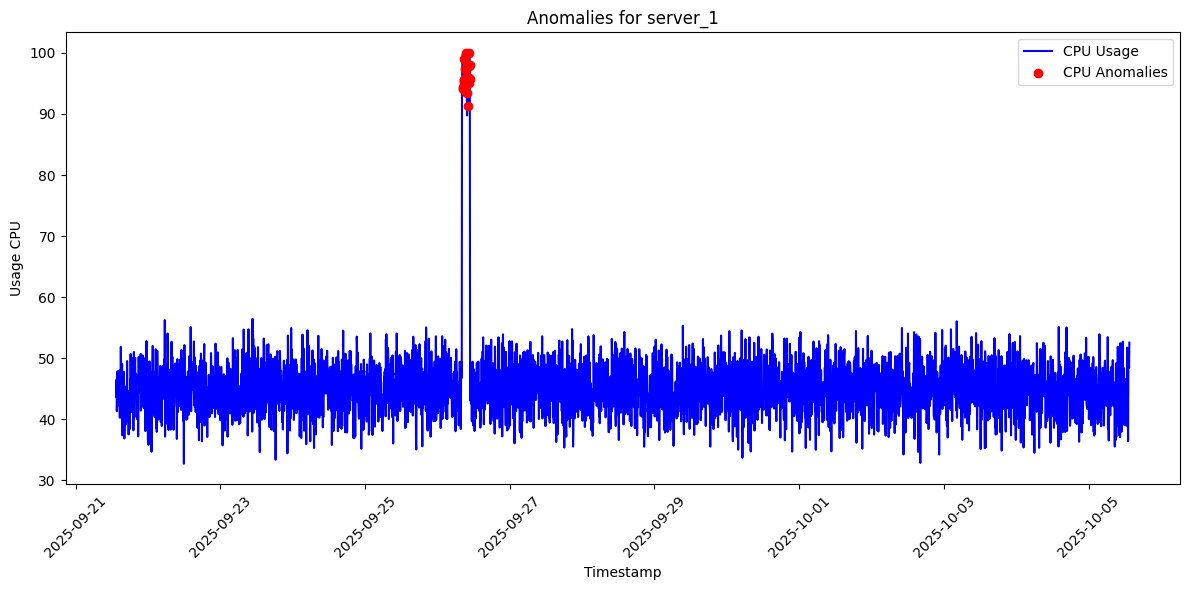

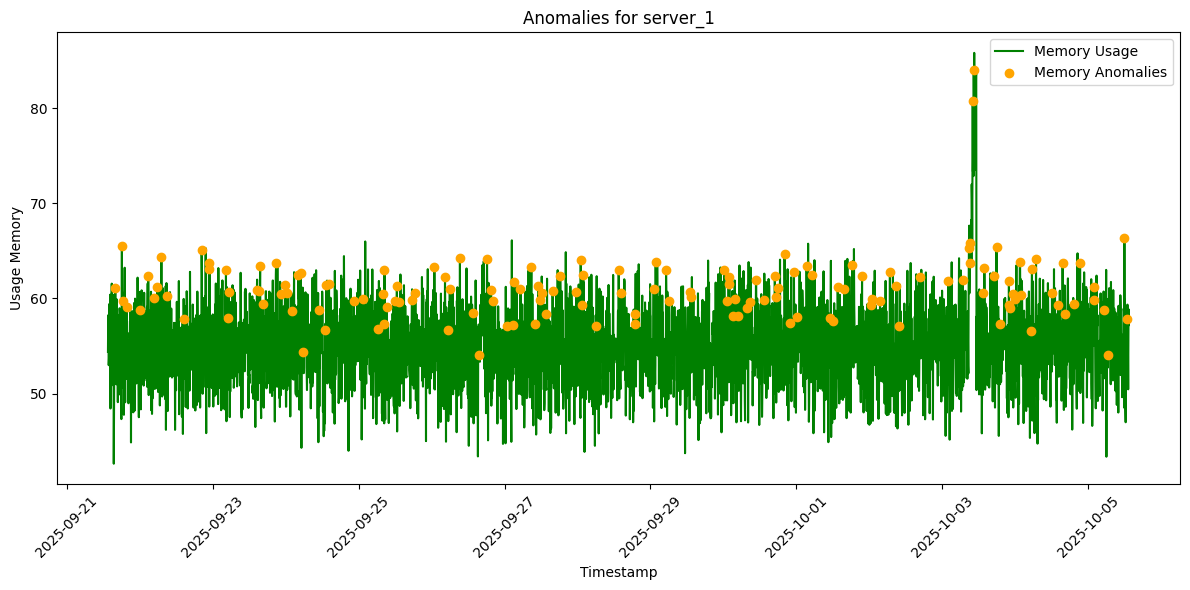

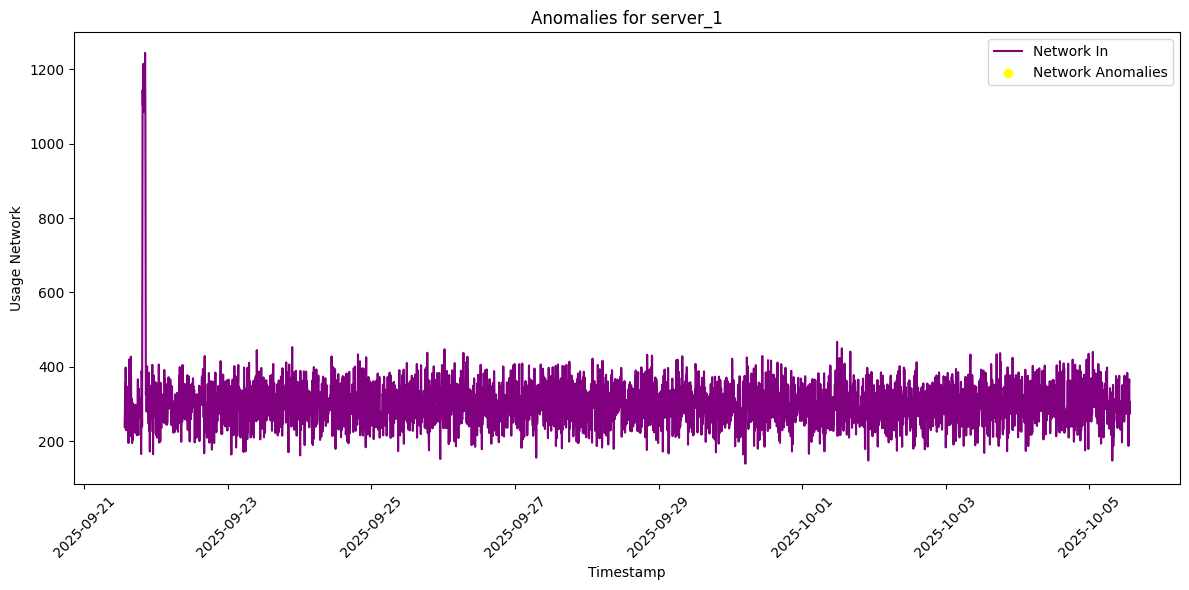

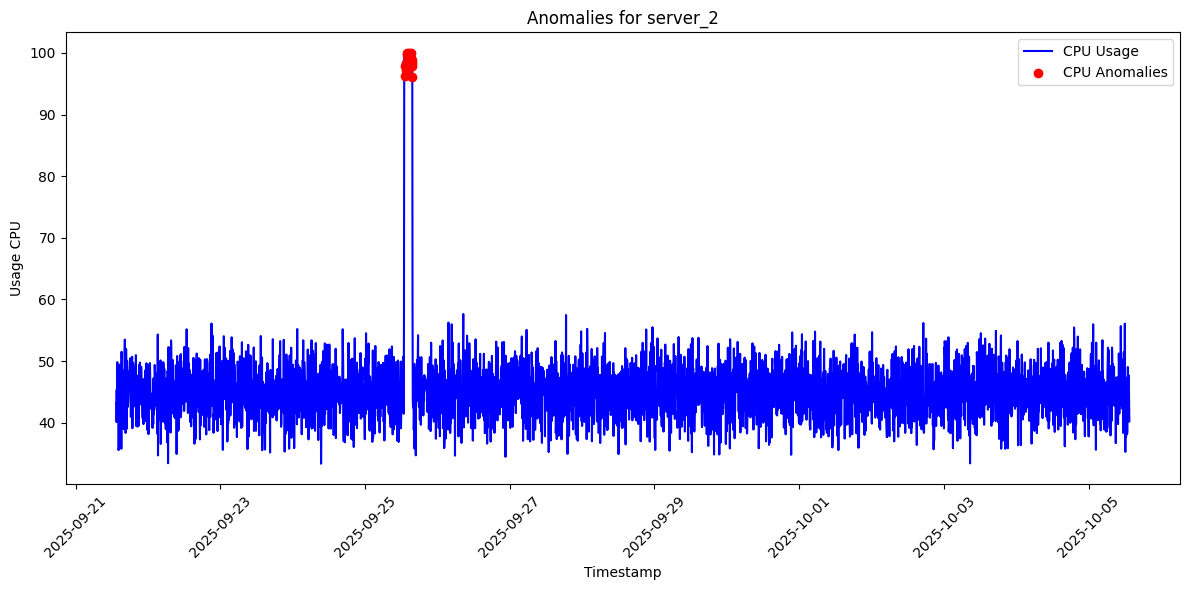

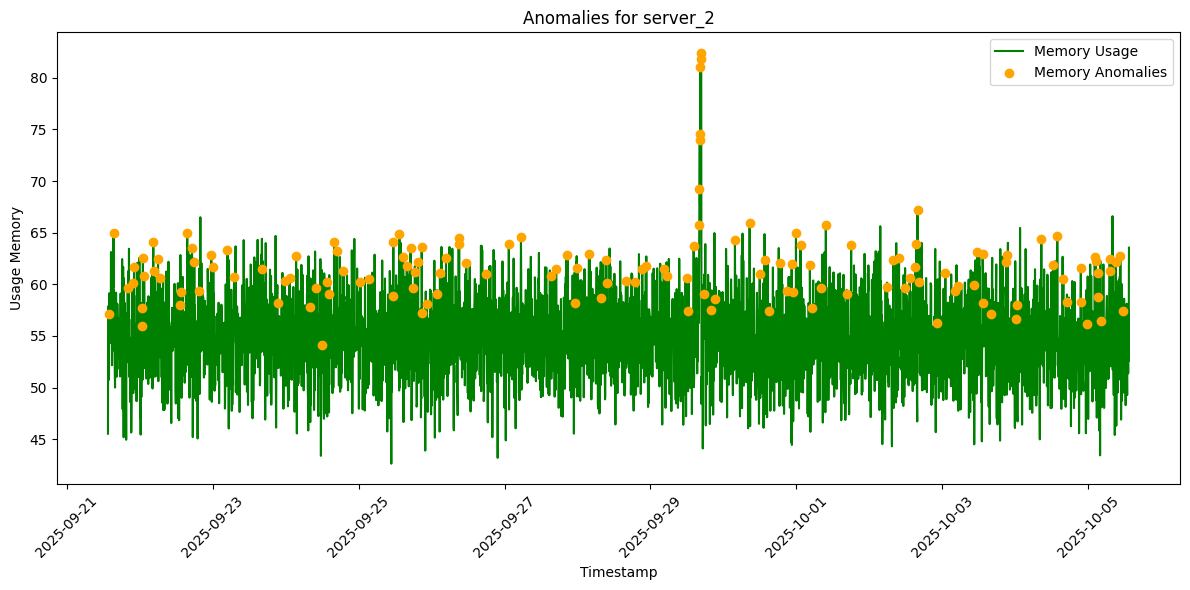

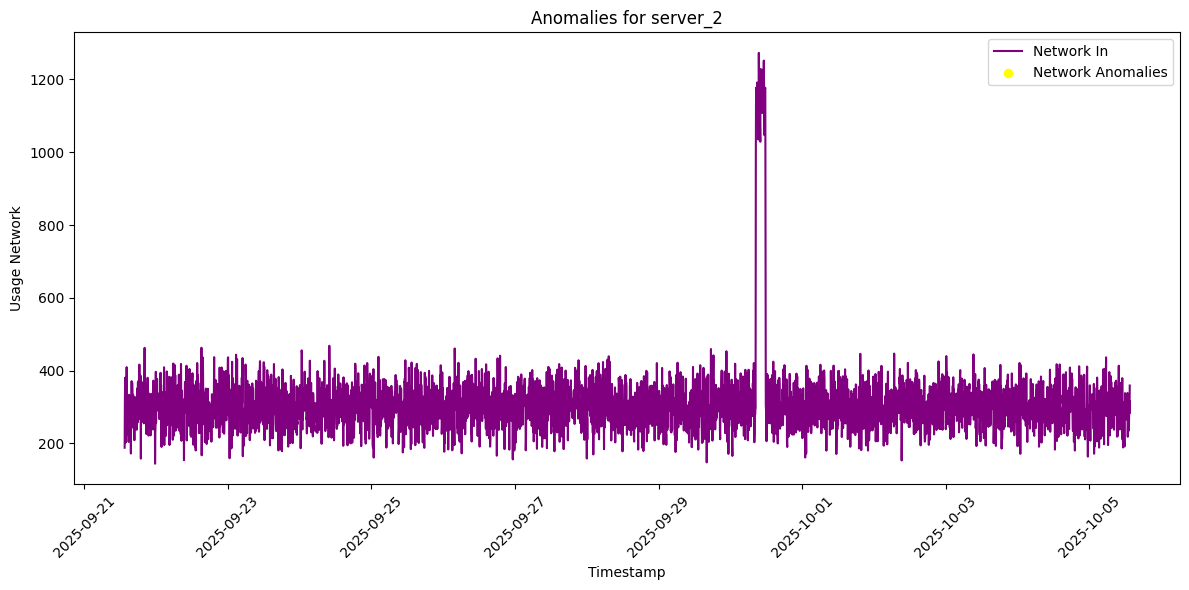

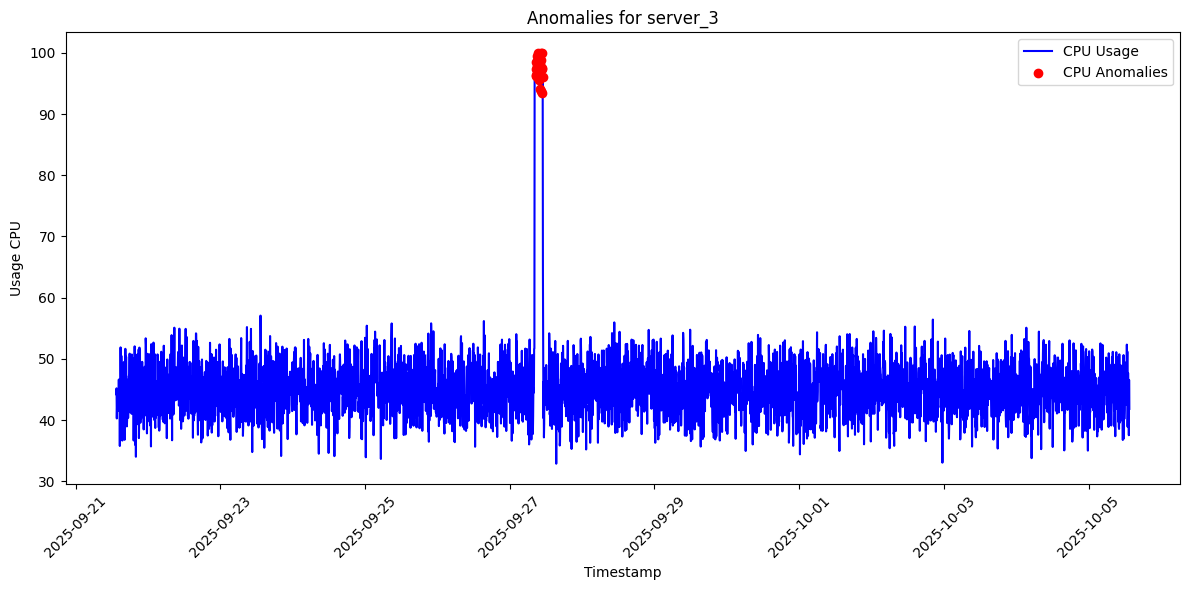

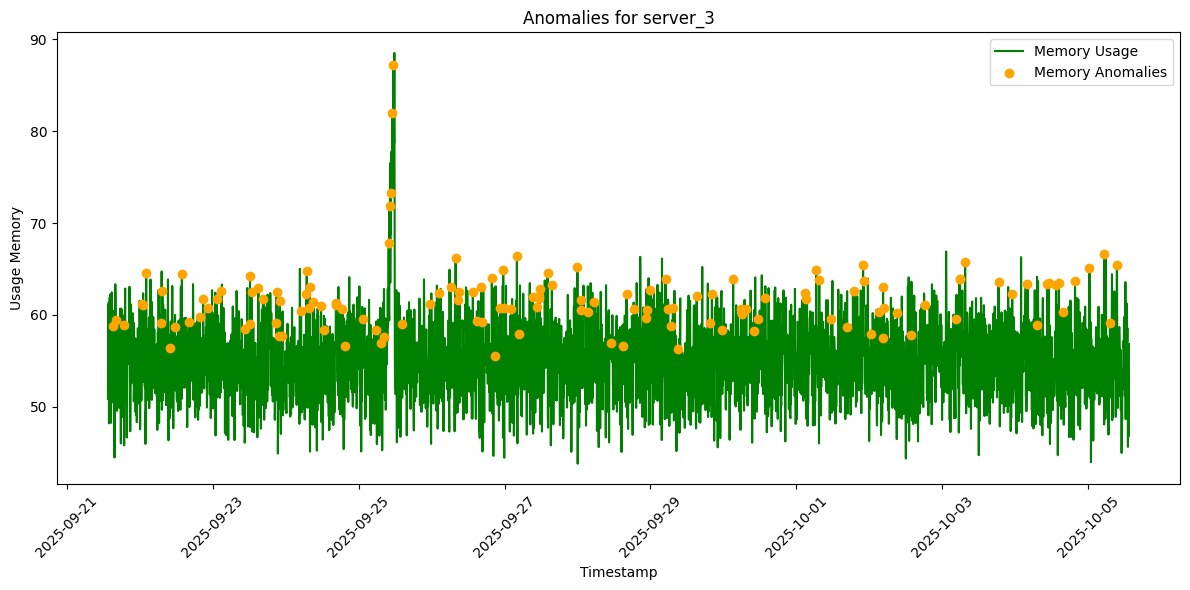

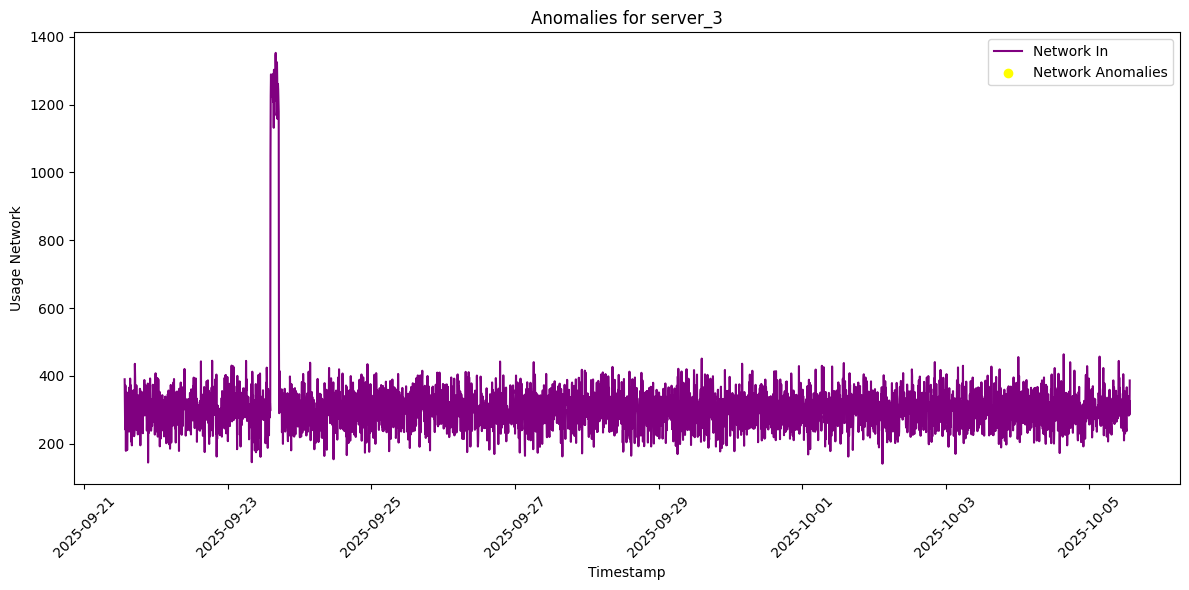

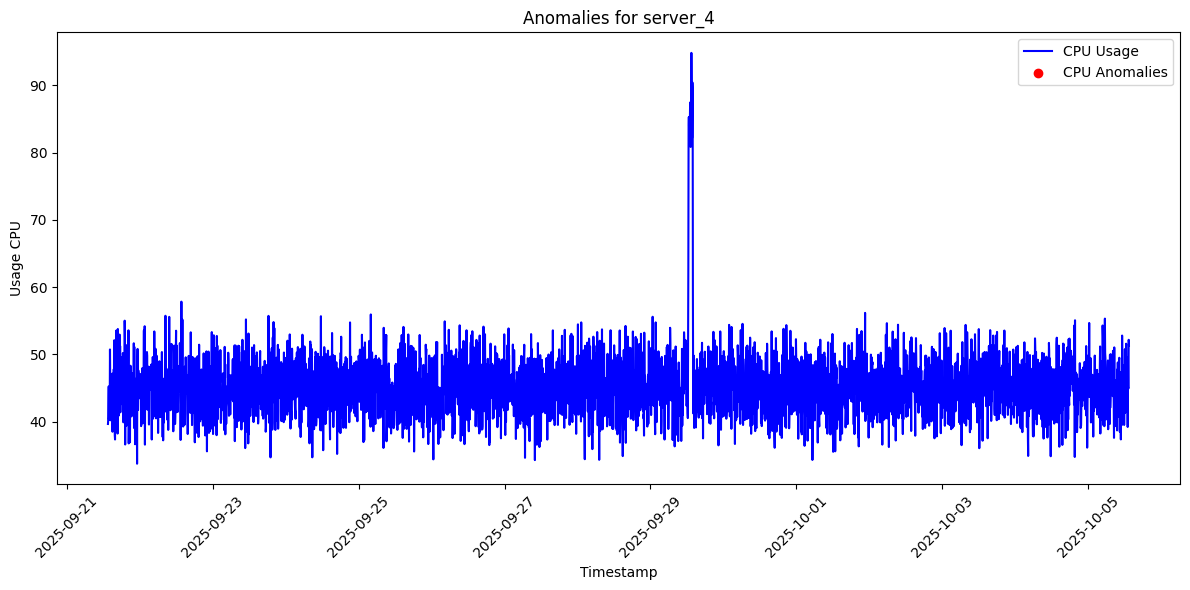

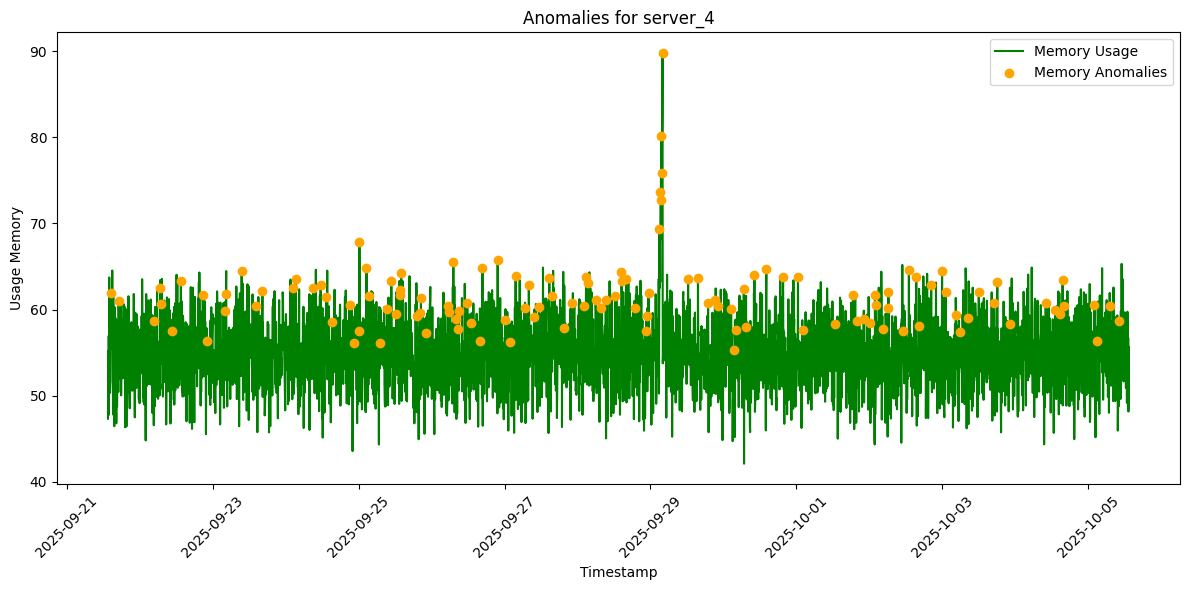

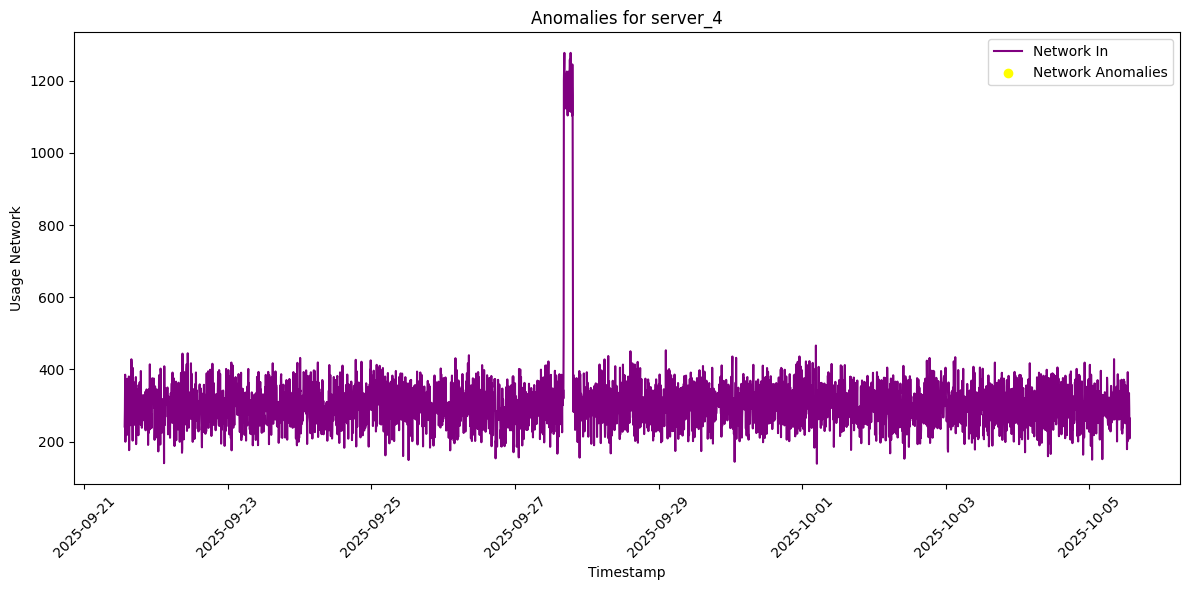

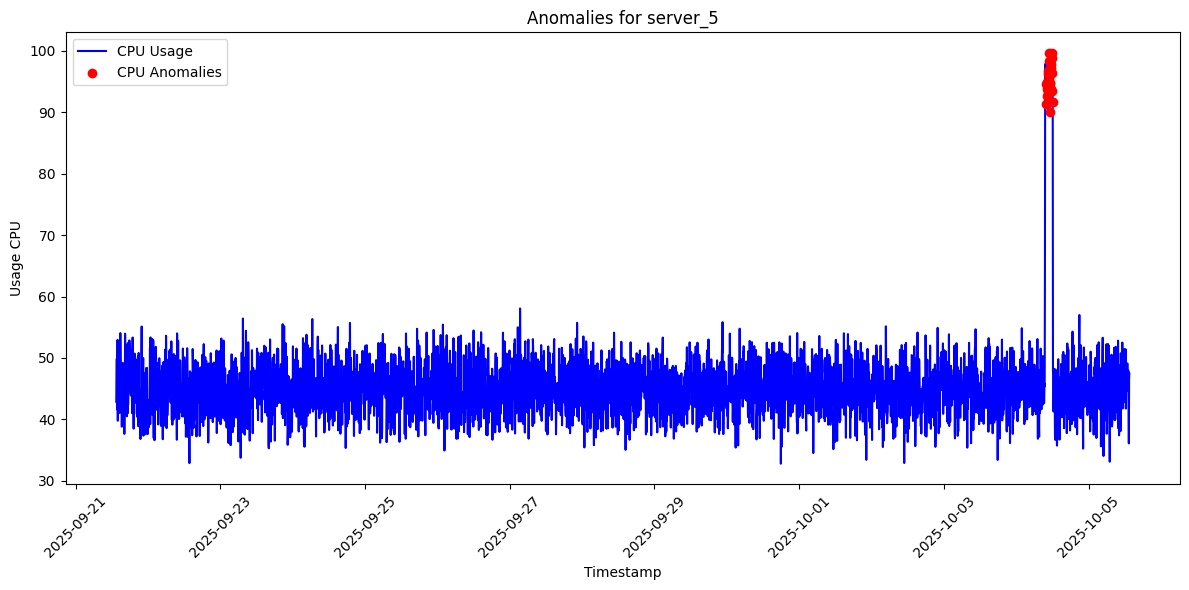

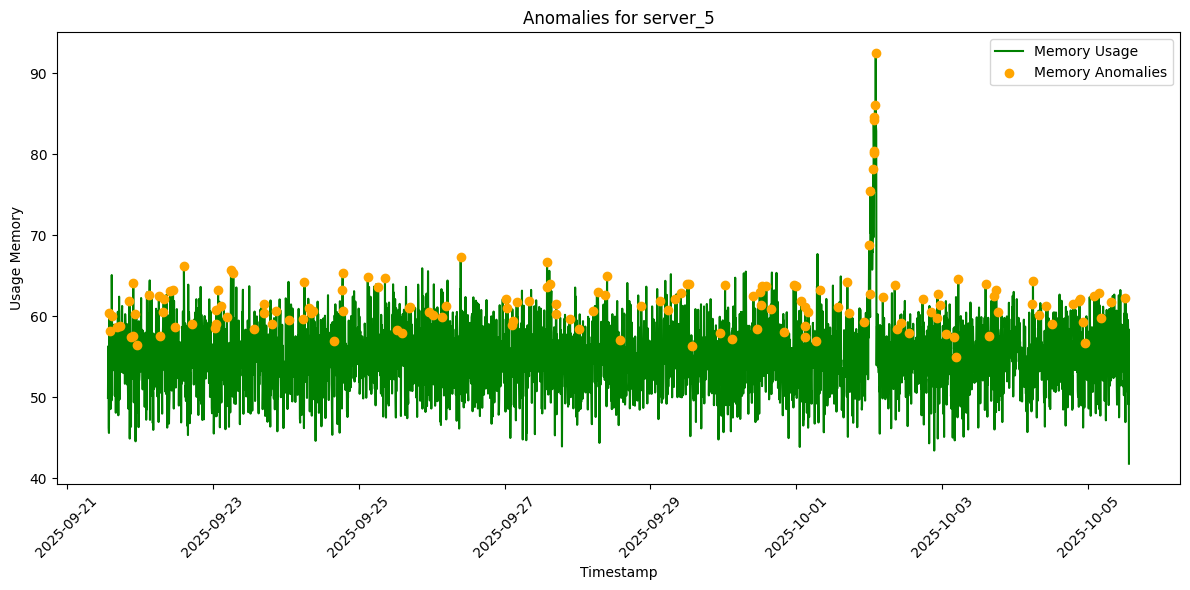

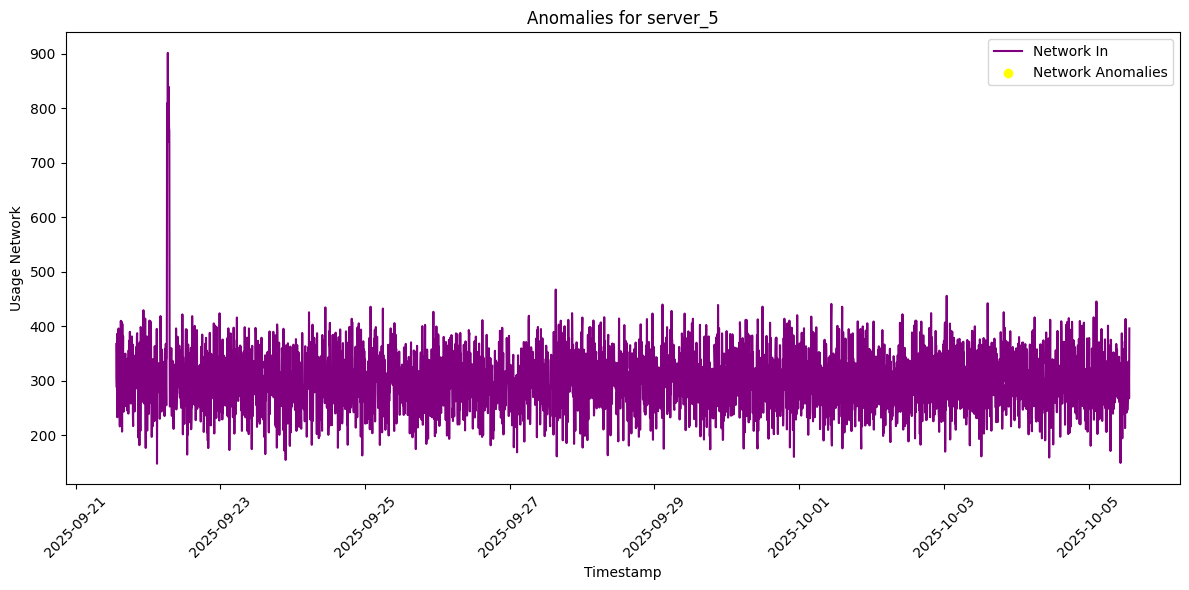

In [18]:
import matplotlib.pyplot as plt

# Loop through each server and create a plot
for server in resampled_df['server_id'].unique():
    # Filter data for the current server
    server_data = resampled_df[resampled_df['server_id'] == server]

    # Filter anomalies based on CPU, Memory, and Network
    cpu_anomaly_data = server_data[server_data['cpu_anomaly'] == True]
    memory_anomaly_data = server_data[server_data['memory_anomaly'] == True]
    network_anomaly_data = server_data[server_data['network_anomaly'] == True]

    # Create a figure
    plt.figure(figsize=(12, 6))

    # Plot CPU usage with CPU anomalies highlighted
    plt.plot(server_data['timestamp'], server_data['cpu_usage'], label='CPU Usage', color='blue')
    plt.scatter(cpu_anomaly_data['timestamp'], cpu_anomaly_data['cpu_usage'], color='red', label='CPU Anomalies', zorder=5)

   

    # Set title and labels
    plt.title(f'Anomalies for {server}')
    plt.xlabel('Timestamp')
    plt.ylabel('Usage CPU')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Show the plot for the current server
    plt.show()
    plt.figure(figsize=(12, 6))
     # Plot Memory usage with Memory anomalies highlighted
    plt.plot(server_data['timestamp'], server_data['memory_usage'], label='Memory Usage', color='green')
    plt.scatter(memory_anomaly_data['timestamp'], memory_anomaly_data['memory_usage'], color='orange', label='Memory Anomalies', zorder=5)
    plt.title(f'Anomalies for {server}')
    plt.xlabel('Timestamp')
    plt.ylabel('Usage Memory')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(12, 6))
    # Plot Network usage with Network anomalies highlighted
    plt.plot(server_data['timestamp'], server_data['network_in'], label='Network In', color='purple')
    plt.scatter(network_anomaly_data['timestamp'], network_anomaly_data['network_in'], color='yellow', label='Network Anomalies', zorder=5)
    plt.title(f'Anomalies for {server}')
    plt.xlabel('Timestamp')
    plt.ylabel('Usage Network')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

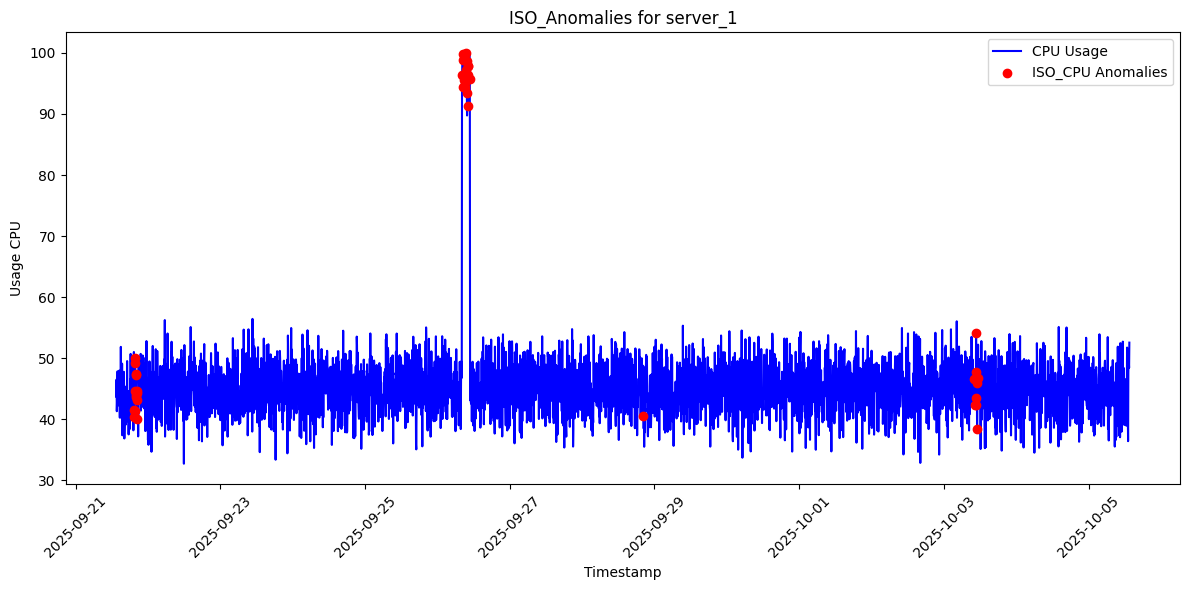

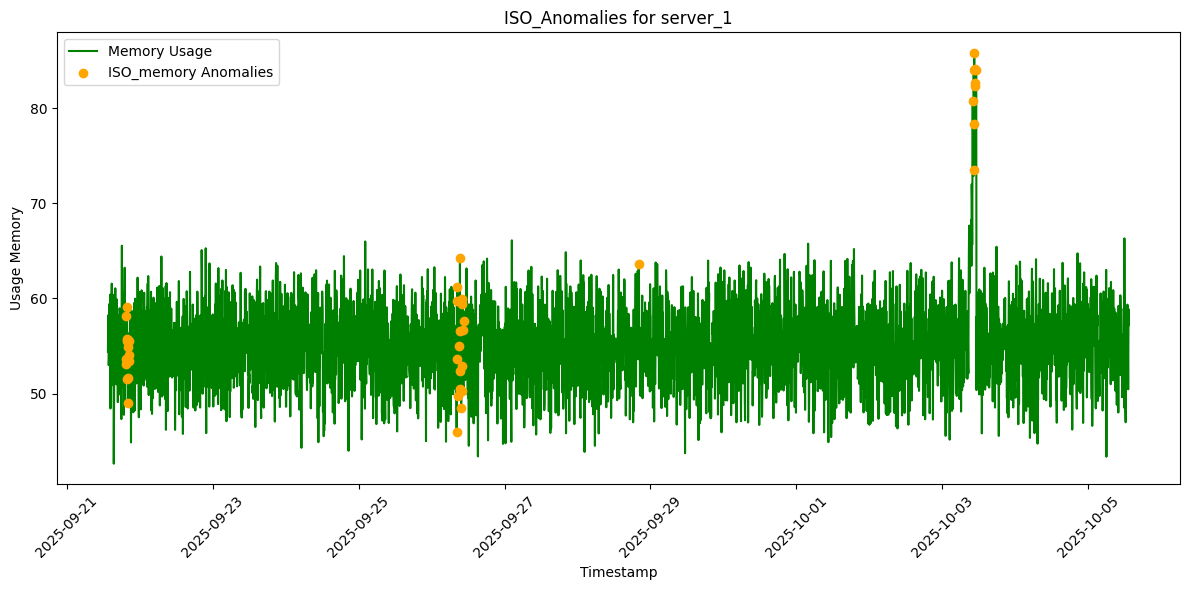

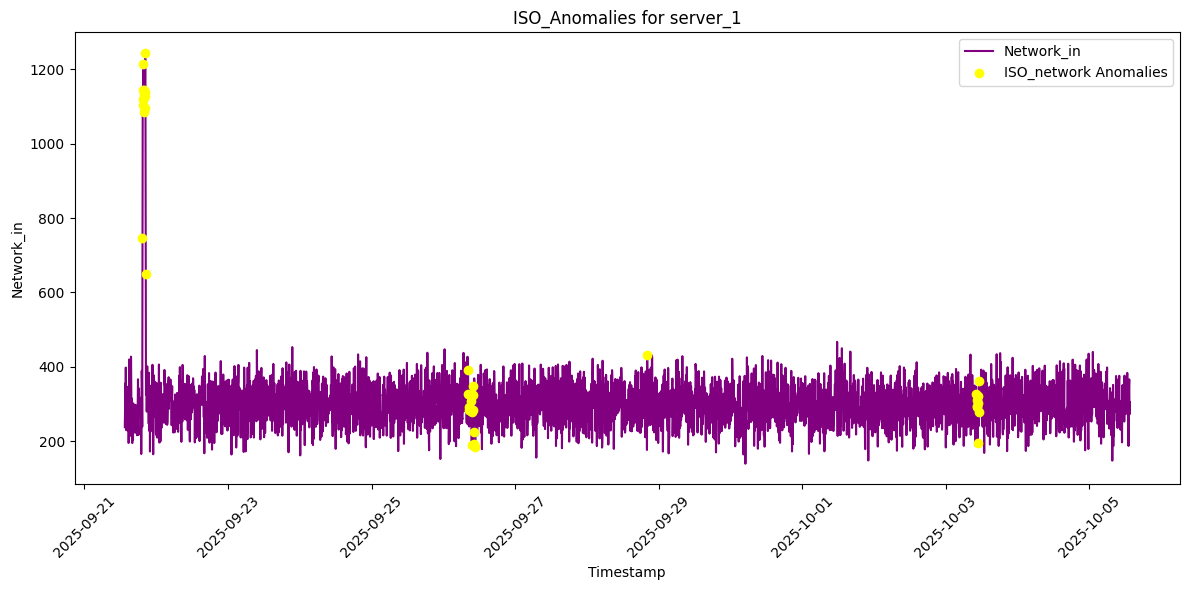

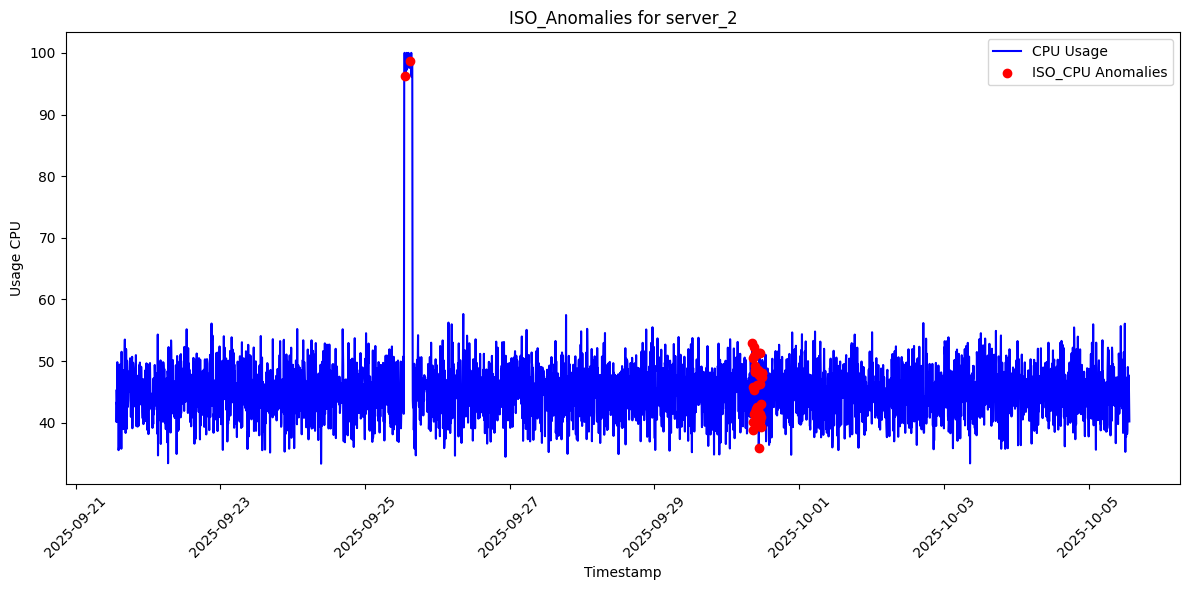

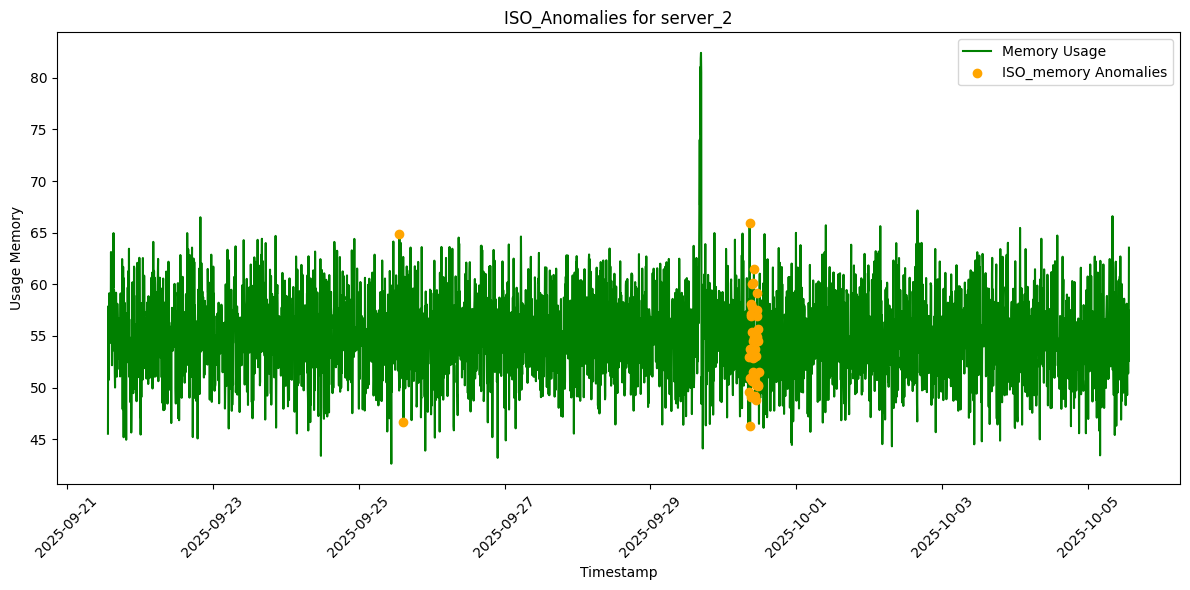

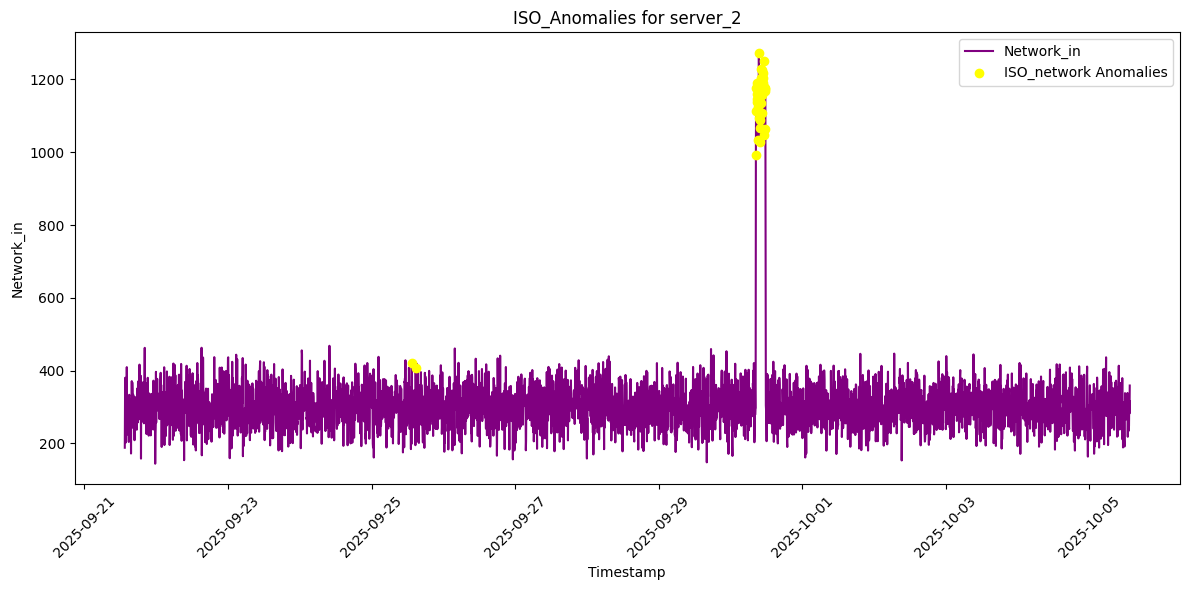

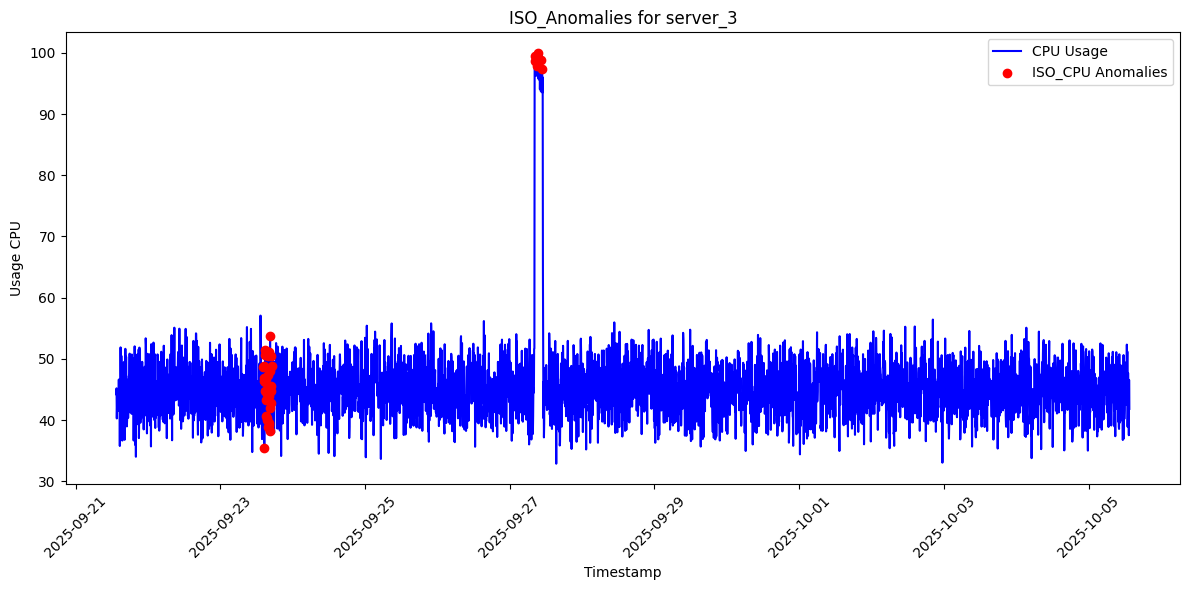

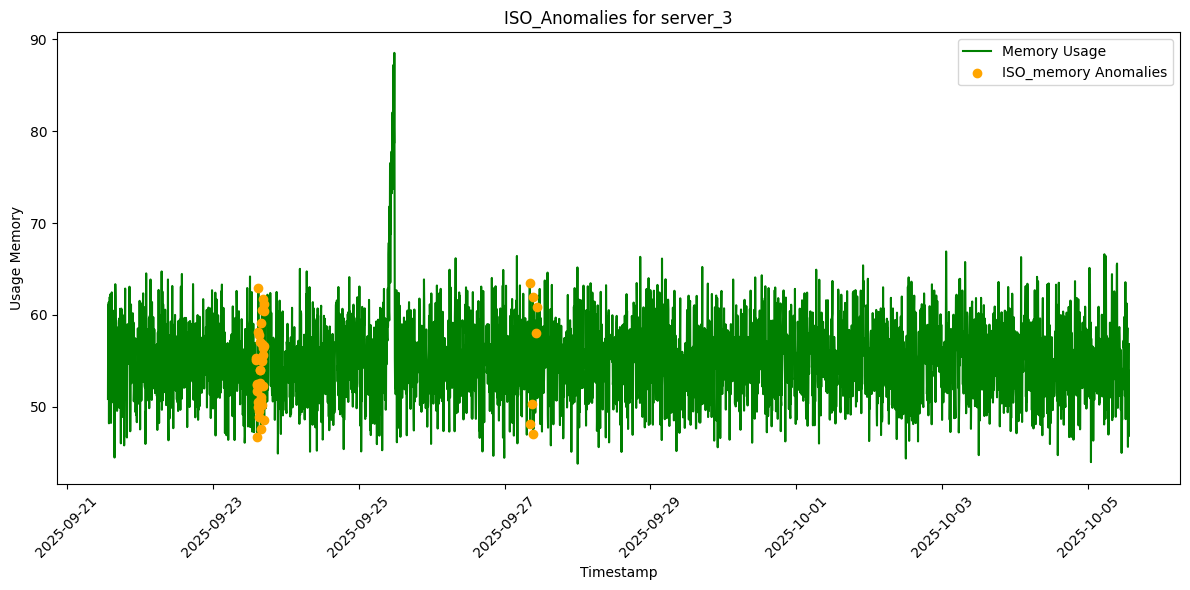

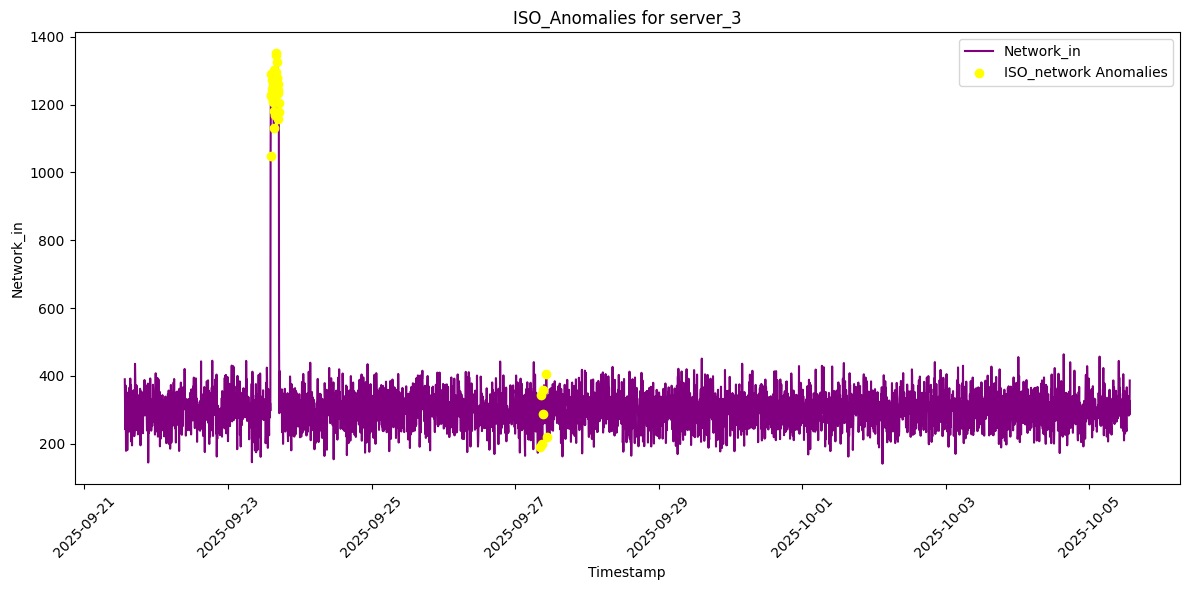

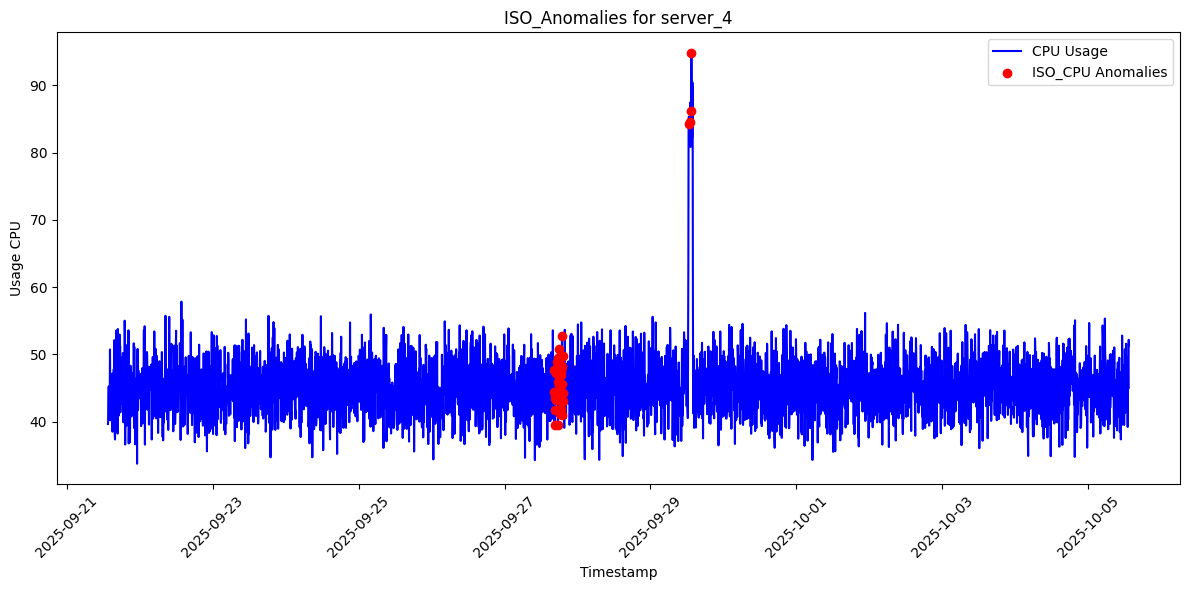

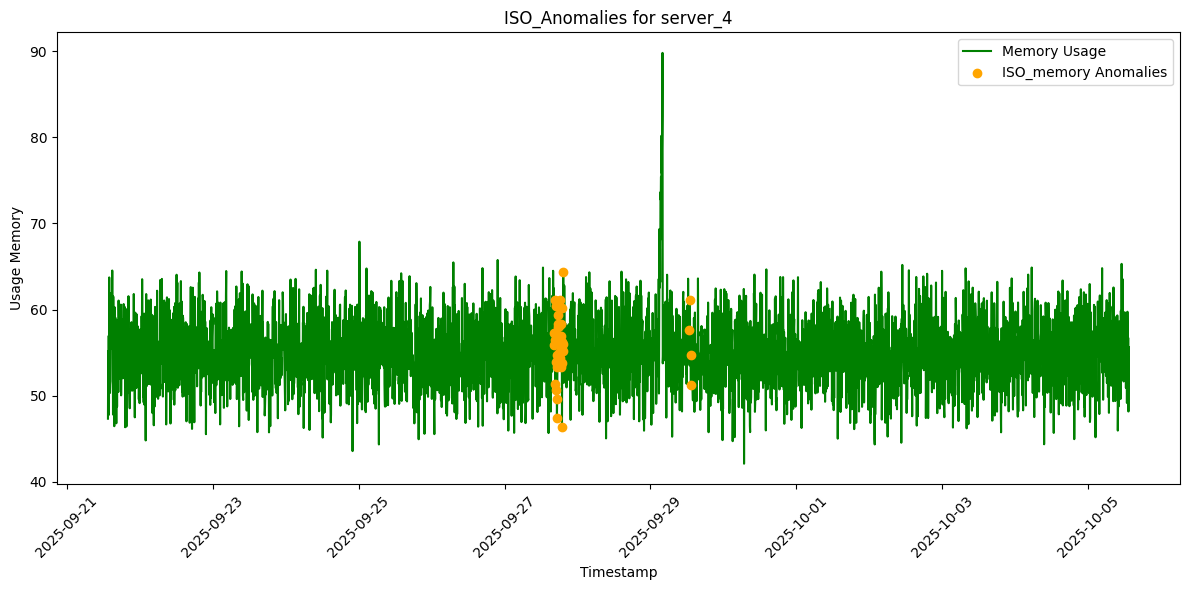

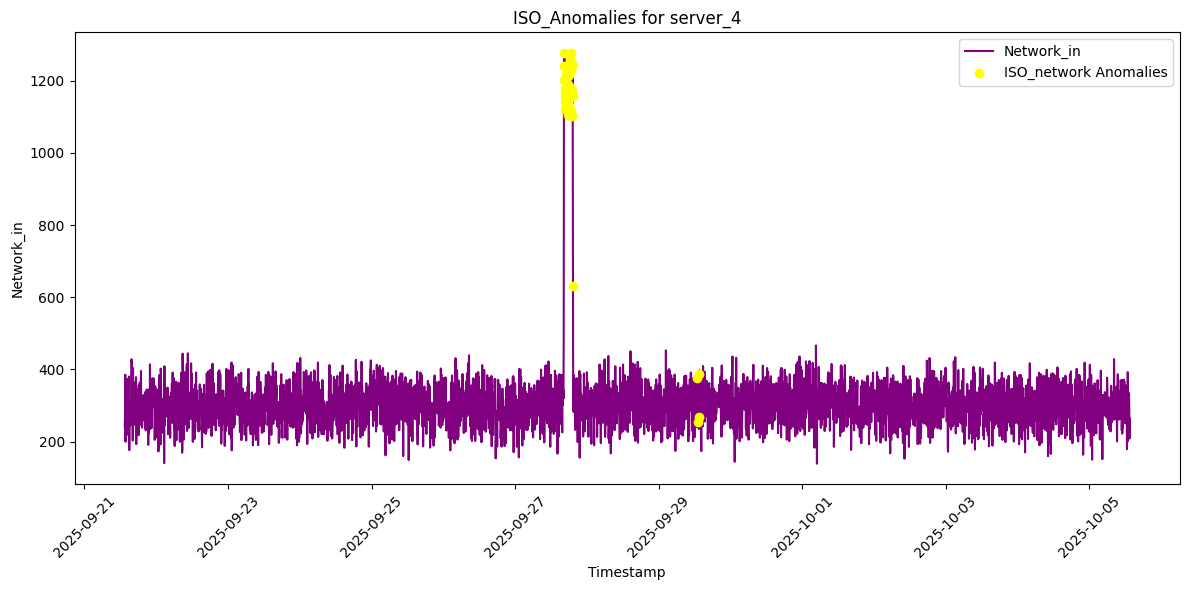

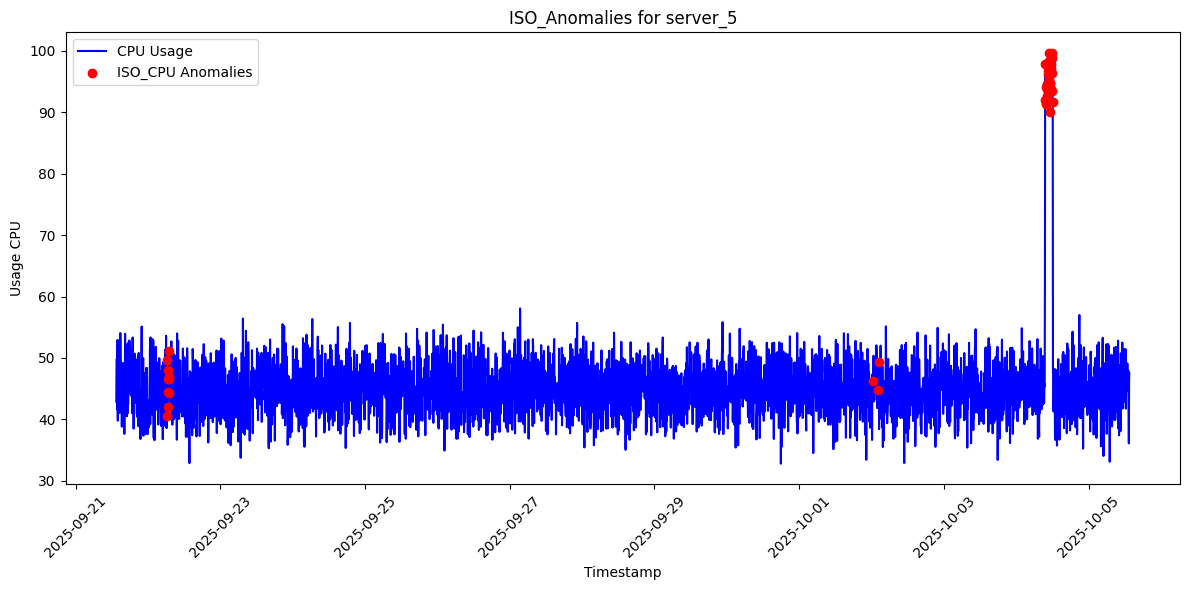

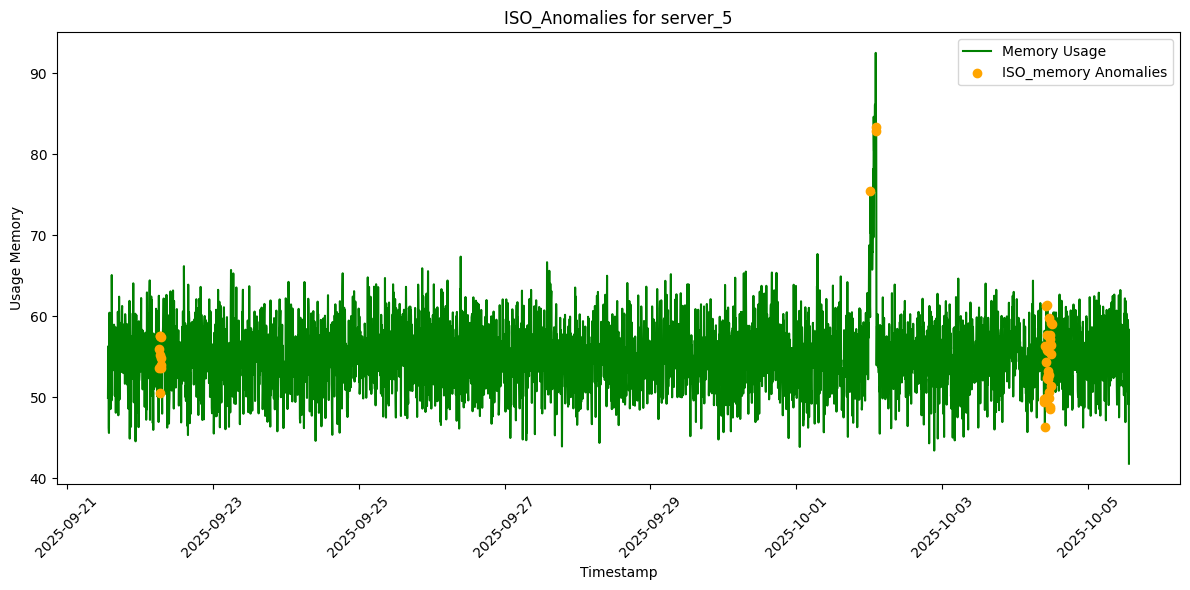

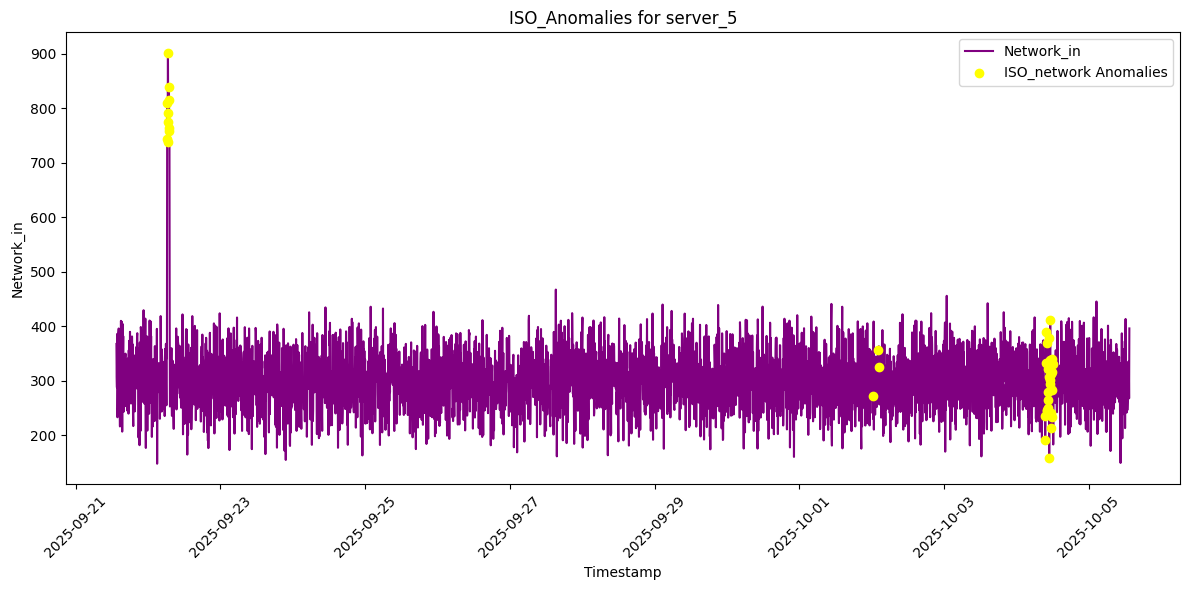

In [22]:
for server in resampled_df['server_id'].unique():
    # Filter data for the current server
    server_data = resampled_df[resampled_df['server_id'] == server]

    # Filter anomalies based on CPU, Memory, and Network
    Iso_anomaly_data = server_data[server_data['anomaly'] == -1]
   
    # Create a figure
    plt.figure(figsize=(12, 6))

    # Plot CPU usage with CPU anomalies highlighted
    plt.plot(server_data['timestamp'], server_data['cpu_usage'], label='CPU Usage', color='blue')
    plt.scatter(Iso_anomaly_data['timestamp'], Iso_anomaly_data['cpu_usage'], color='red', label='ISO_CPU Anomalies', zorder=5)

   

    # Set title and labels
    plt.title(f'ISO_Anomalies for {server}')
    plt.xlabel('Timestamp')
    plt.ylabel('Usage CPU')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Show the plot for the current server
    plt.show()
    plt.figure(figsize=(12, 6))

    # Plot CPU usage with CPU anomalies highlighted
    plt.plot(server_data['timestamp'], server_data['memory_usage'], label='Memory Usage', color='green')
    plt.scatter(Iso_anomaly_data['timestamp'], Iso_anomaly_data['memory_usage'], color='orange', label='ISO_memory Anomalies', zorder=5)

   

    # Set title and labels
    plt.title(f'ISO_Anomalies for {server}')
    plt.xlabel('Timestamp')
    plt.ylabel('Usage Memory')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Show the plot for the current server
    plt.show()
    plt.figure(figsize=(12, 6))

    # Plot CPU usage with CPU anomalies highlighted
    plt.plot(server_data['timestamp'], server_data['network_in'], label='Network_in', color='purple')
    plt.scatter(Iso_anomaly_data['timestamp'], Iso_anomaly_data['network_in'], color='yellow', label='ISO_network Anomalies', zorder=5)

   

    # Set title and labels
    plt.title(f'ISO_Anomalies for {server}')
    plt.xlabel('Timestamp')
    plt.ylabel('Network_in')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Show the plot for the current server
    plt.show()
    